# Using NCO utilities ncks and ncrcat to subset CETB files by location and concatenate by time series

To begin, you need to know the map coordinates of the spatial subset you want.

You can use various utilities to do this, we have written the python package cetbtools.ease2conv to help with it.

For this example, I want the upper left quadrant of the EASE2_N25km grid, which is bounded by
the upper left corner of the grid and the North Pole at the center of the grid.

In [45]:
%pylab inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from cetbtools.ease2conv import Ease2Transform

Populating the interactive namespace from numpy and matplotlib


In [46]:
subULrow, subULcol = -0.5, -0.5
subLRrow, subLRcol = 359.5, 359.5
N25 = Ease2Transform("EASE2_N25km")
subULx, subULy = N25.grid_to_map(subULrow, subULcol)
subLRx, subLRy = N25.grid_to_map(subLRrow, subLRrow)
print "Subset UL x,y = %.3f, %.3f" % (subULx, subULy)
print "Subset LR x,y = %.3f, %.3f" % (subLRx, subLRy)

Subset UL x,y = -9000000.000, 9000000.000
Subset LR x,y = 0.000, 0.000


So these min/max values for cols and rows can be passed to ncks to subset the TB variable from a CETB file with:

ncks -d cols,-9000000.,0. -d rows,0.,9000000. -v TB EASE2_N25km.F13_SSMI.2003001.19H.E.GRD.CSU.v0.1.nc d001.19H.ul.nc

This subsets the upper left quadrant of the EASE2_N25km grid into the file d001.19H.ul.nc.

In [47]:
%cd /projects/PMESDR/vagrant/brodzik/

/projects/PMESDR/vagrant/brodzik


In [48]:
filename = "d001.19H.ul.nc"
fid = Dataset( filename, "r", format="NETCDF4")
fid

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    Conventions: CF-1.6
    title: MEaSUREs Calibrated Passive Microwave Daily EASE-Grid 2.0 Brightness Temperature ESDR
    product_version: v0.01
    software_version_id: 0.0.3
    software_repository: git@bitbucket.org:nsidc/measures-byu.git
    source: TBD(list of swath files used)
    source_version_id: TBD(list of GSX versions, 1 per source file)
    history: Tue Mar  1 13:35:02 2016: ncks -d cols,-9000000.,0. -d rows,0.,9000000. -v TB F13_CSU_N_2003001/EASE2_N25km.F13_SSMI.2003001.19H.E.GRD.CSU.v0.1.nc d001.19H.ul.nc
TBD(bgi or sir command line)
    comment: Prototype version of this product, intended for user evaluation and feedback.
    references: Data set documentation: http://nsidc.org/data/nsidc-0630.html
Algorithm Theoretical Basis Document: http://nsidc.org/pmesdr/files/2015/09/MEaSUREs_CETB_ATBD_v0.10.pdf
Ancillary File: TBD
    summary: An improved, enhanced-resolution, gridded pa

In [49]:
tb = fid.variables['TB'][:]

In [50]:
np.shape(tb)

(1, 360, 360)

In [51]:
tb = np.squeeze(tb)
np.shape(tb)

(360, 360)

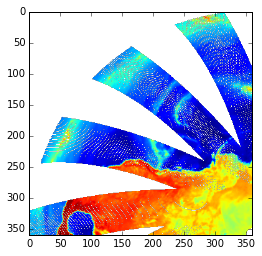

In [52]:
plt.imshow(tb)

Then for each subset file you must change "time" from a fixed dimension to a record (unlimited dimension), using

ncks -O --mk_rec_dmn time d002.19H.ul.nc d002.19H.ul.new.nc

(this will change the ncdump -h information from: 

<blockquote>
<p>dimensions:
	<p>time = 1 ;
</blockquote>
    
to   

<blockquote>
<p>dimensions:
	<p>time = UNLIIMITED ; // (1 currently)
</blockquote>
Then for a full list of files you can concatenate them in the time dimension with:

ncrcat -O *.new.nc all_days.19H.ul.nc

Thanks to this NASA recipe %pylab inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as npfor tips here:

http://disc.sci.gsfc.nasa.gov/recipes/?q=recipes/How-to-Concatenate-the-Time-Dimension-of-netCDF-Files-with-NCO

In [53]:
combfile = "d001-003.19H.ul.nc"
combfid = Dataset(combfile, 'r', format="NETCDF")
combfid

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    Conventions: CF-1.6
    title: MEaSUREs Calibrated Passive Microwave Daily EASE-Grid 2.0 Brightness Temperature ESDR
    product_version: v0.01
    software_version_id: 0.0.3
    software_repository: git@bitbucket.org:nsidc/measures-byu.git
    source: TBD(list of swath files used)
    source_version_id: TBD(list of GSX versions, 1 per source file)
    history: Tue Mar  1 13:56:59 2016: ncrcat -O d001.19H.ul.new.nc d002.19H.ul.new.nc d003.19H.ul.new.nc d001-003.19H.ul.nc
Tue Mar  1 13:55:13 2016: ncks -O --mk_rec_dmn time d001.19H.ul.nc d001.19H.ul.new.nc
Tue Mar  1 13:35:02 2016: ncks -d cols,-9000000.,0. -d rows,0.,9000000. -v TB F13_CSU_N_2003001/EASE2_N25km.F13_SSMI.2003001.19H.E.GRD.CSU.v0.1.nc d001.19H.ul.nc
TBD(bgi or sir command line)
    comment: Prototype version of this product, intended for user evaluation and feedback.
    references: Data set documentation: http://nsidc.org/data/

In [54]:
np.shape(combfid.variables["TB"][:])

(3, 360, 360)

In [55]:
slice0 = combfid.variables["TB"][:][0,:,:]

In [56]:
np.shape(slice)

(360, 360)

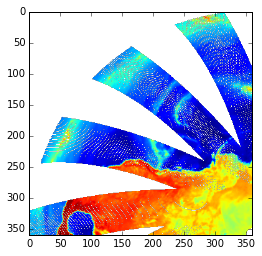

In [57]:
plt.imshow(slice0)

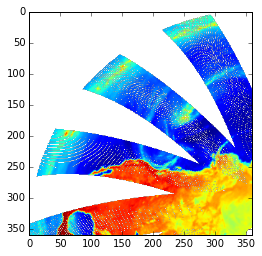

In [58]:
slice1 = combfid.variables["TB"][:][1,:,:]
plt.imshow(slice1)

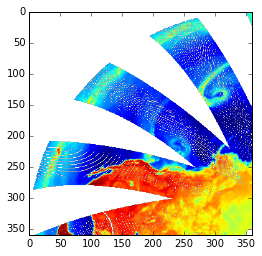

In [59]:
slice2 = combfid.variables["TB"][:][2,:,:]
plt.imshow(slice2)

# Test pixel map coordinates for Melt Onset analysis

For Karakoram pixel at 31.1N, 75.8E:

In [60]:
lat, lon = 31.1, 75.8
row, col = N25.geographic_to_grid(lat, lon)
x, y = N25.grid_to_map(row, col)
print row,col
print x, y

421.079648174 602.860400081
6084010.00203 -1539491.20435


For Himalaya pixel at 38.1N, 88.3E:

In [61]:
lat, lon = 38.1, 88.3
row, col = N25.geographic_to_grid(lat, lon)
x, y = N25.grid_to_map(row, col)
print row,col
print x, y

366.131216752 582.928960868
5585724.0217 -165780.418793
